In [1]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font', family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
# parse_dates : 날짜 변수 식별
df_raw = pd.read_csv('data/currency.csv', parse_dates=['APPL_DATE'])
df_raw.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


### 변동 추세 확인

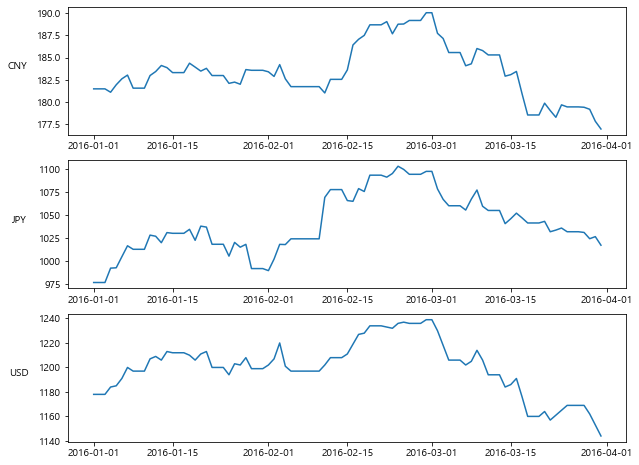

In [5]:
# 중국 위엔화와 엔화/달러 단위가 다르기 때문에 각각 그래프를 생성
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 8))

for(ax, idx, currency) in zip([ax1, ax2, ax3], [311, 312, 313], ['CNY', 'JPY', 'USD']):
    ax.plot('APPL_DATE', 'STD_RATE', data = df_raw[df_raw['CURRENCY'] == currency])
    ax.set_ylabel(currency, rotation = 0, labelpad = 20)

In [7]:
# CNY 데이터 선택 후 APPL_DATE를 index로 설정
df_CNY = df_raw[df_raw['CURRENCY'] == 'CNY'].set_index('APPL_DATE')
df_CNY.drop(['CURRENCY', 'USD_CONV_DATE'], axis = 1, inplace = True)

df_JPY = df_raw[df_raw['CURRENCY'] == 'JPY'].set_index('APPL_DATE')
df_JPY.drop(['CURRENCY', 'USD_CONV_DATE'], axis = 1, inplace = True)

df_USD = df_raw[df_raw['CURRENCY'] == 'USD'].set_index('APPL_DATE')
df_USD.drop(['CURRENCY', 'USD_CONV_DATE'], axis = 1, inplace = True)
df_CNY.head()

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


### 학습, 평가 데이터 분할

In [8]:
#train, test 데이터 분할, 비율 기준 mask 지정
train_size = 0.9
len_idx = len(df_CNY.index)
mask = (np.arange(len_idx) / len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [9]:
# mask 이용한 데이터 분할
df_CNY_train = df_CNY[mask]
df_CNY_test = df_CNY[~mask]

print('학습용 CNY shape :', df_CNY_train.shape)
print('평가용 CNY shape :', df_CNY_test.shape)

학습용 CNY shape : (82, 1)
평가용 CNY shape : (9, 1)


### 차분을 통하여 정상성 데이터로 변환

<AxesSubplot:xlabel='APPL_DATE'>

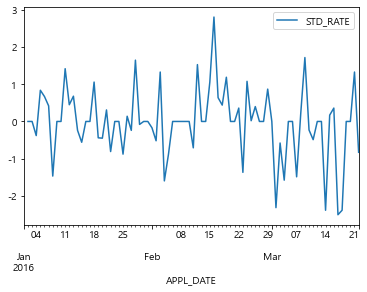

In [10]:
# 1차 차분
# shift(n): 앞의 n번째 행의 데이터를 가져옴
df_CNY_diff1 = df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()

<AxesSubplot:xlabel='APPL_DATE'>

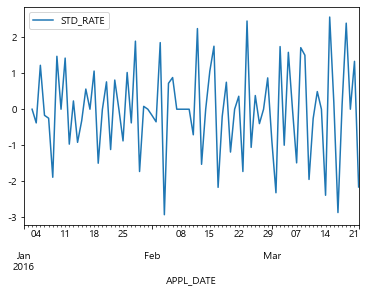

In [14]:
# 2차 차분
df_CNY_diff2 = df_CNY_train - 2 * (df_CNY_train.shift(1)) + (df_CNY_train.shift(2))
df_CNY_diff2.plot()

In [15]:
# 2차 차분으로 결정

### 자기상관 함수 및 부분 자기상관 함수

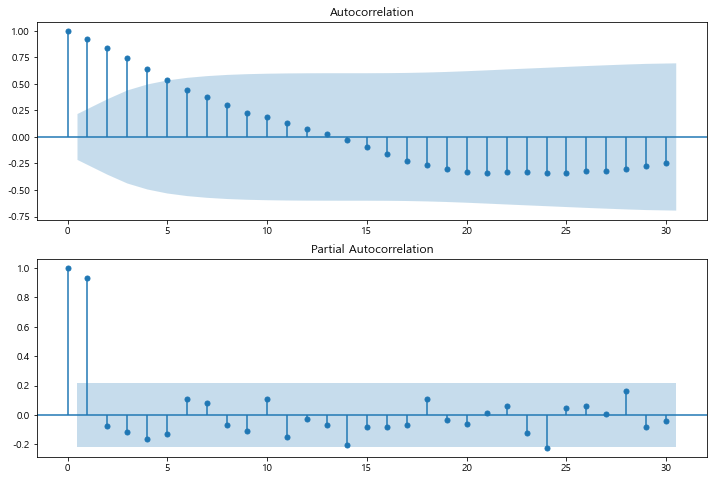

In [16]:
lag_size = 30
fig = plt.figure(figsize = (12, 8))

ax1 = fig.add_subplot(211)
fig = plot_acf(df_CNY_train['STD_RATE'], lags = lag_size, ax = ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df_CNY_train['STD_RATE'], lags = lag_size, ax = ax2)

In [17]:
# p = 1, q = 0

### 시계열 모델

In [18]:
ts_model_cny = ARIMA(df_CNY_train, order = (1, 2, 0))

#데이터 적합
ts_result_cny = ts_model_cny.fit(trend = 'c', full_output = True)
print(ts_result_cny.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.512
Method:                       css-mle   S.D. of innovations              1.132
Date:                Tue, 08 Feb 2022   AIC                            253.025
Time:                        14:16:23   BIC                            260.171
Sample:                    01-03-2016   HQIC                           255.890
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0022      0.088     -0.024      0.981      -0.175       0.171
ar.L1.D2.STD_RATE    -0.4389      0.102     -4.322      0.000      -0.638      -0.240
                        

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will 

### 예측 및 결과 해석

starttime 2016-03-23 00:00:00
endtime 2016-03-31 00:00:00


C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


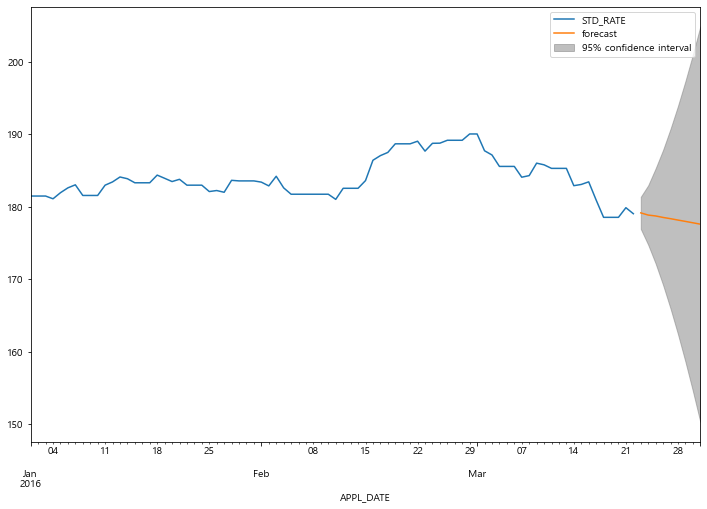

In [19]:
start_time = df_CNY_test.index.min()
print('starttime', start_time)
end_time = df_CNY_test.index.max()
print('endtime', end_time)

fig, ax = plt.subplots(figsize = (12, 8))
ax = df_CNY_train.plot(ax = ax)

fig = ts_result_cny.plot_predict(start = start_time, end = end_time, ax = ax, plot_insample = False)

- 2016년 3월 31일까지의 예측값 -> 지속적으로 감소할 것으로 예측 

In [20]:
# 전체 기간의 실제값, 예측값 확인

start_time = pd.to_datetime('2016-01-03')
y_pred = ts_result_cny.predict(start = start_time, end = end_time, typ = 'levels')
df_merge = df_CNY
df_merge['예측값'] = y_pred
df_merge.head()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.477844
2016-01-04,181.10,181.476897
2016-01-05,181.94,180.883667


In [21]:
df_merge.shape

(91, 2)

<AxesSubplot:xlabel='APPL_DATE'>

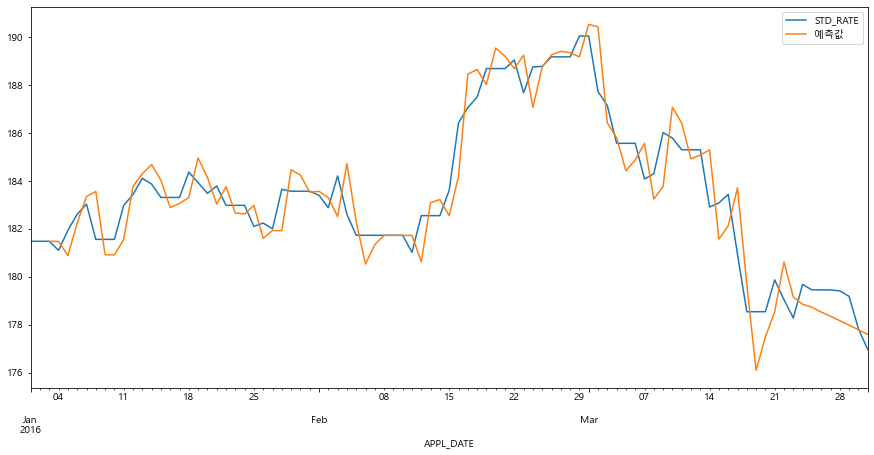

In [22]:
df_merge.plot(y = ['STD_RATE', '예측값'], figsize = (15, 7))

In [27]:
df_merge.isnull().sum()

STD_RATE    0
예측값         2
dtype: int64

### mape 계산

In [47]:
df_merge2 = df_merge.dropna(axis = 0)
df_merge2

,STD_RATE,예측값
APPL_DATE,,
2016-01-03,181.48,181.477844
2016-01-04,181.10,181.476897
2016-01-05,181.94,180.883667
2016-01-06,182.61,182.241480
2016-01-07,183.03,183.351505
...,...,...
2016-03-27,179.45,178.352474
2016-03-28,179.41,178.162995
2016-03-29,179.18,177.978127


In [ ]:
# 결측치 제거하지 않고 돌렸을 때

In [28]:
mape = (abs(df_merge['STD_RATE'] - df_merge['예측값']) / df_merge['STD_RATE']).sum() / len(df_merge) * 100

In [29]:
mape

0.47758749362649966

In [50]:
# 결측치 제거하고 돌렸을 때

In [31]:
mape2 = (abs(df_merge2['STD_RATE'] - df_merge2['예측값']) / df_merge2['STD_RATE']).sum() / len(df_merge2) * 100

In [32]:
mape2

0.48831979685406146

In [34]:
df_merge2.reset_index(inplace = True)

In [35]:
df_merge2['STD_RATE']

0     181.48
1     181.10
2     181.94
3     182.61
4     183.03
       ...  
84    179.45
85    179.41
86    179.18
87    177.83
88    176.96
Name: STD_RATE, Length: 89, dtype: float64

In [37]:
df_merge2['예측값']

0     181.477844
1     181.476897
2     180.883667
3     182.241480
4     183.351505
         ...    
84    178.352474
85    178.162995
86    177.978127
87    177.788132
88    177.597285
Name: 예측값, Length: 89, dtype: float64

In [38]:
from sklearn.metrics import mean_absolute_percentage_error

In [40]:
mean_absolute_percentage_error(df_merge2['예측값'], df_merge2['STD_RATE'])*100

0.48843534871940597

## JPY, USD

In [51]:
# mask 이용한 데이터 분할
df_JPY_train = df_JPY[mask]
df_JPY_test = df_JPY[~mask]

df_USD_train = df_USD[mask]
df_USD_test = df_USD[~mask]

print('학습용 JPY shape :', df_JPY_train.shape)
print('평가용 JPY shape :', df_JPY_test.shape)
print('학습용 USD shape :', df_USD_train.shape)
print('평가용 USD shape :', df_USD_test.shape)

학습용 JPY shape : (82, 1)
평가용 JPY shape : (9, 1)
학습용 USD shape : (82, 1)
평가용 USD shape : (9, 1)


### 차분을 통하여 정상성 데이터로 변환

<AxesSubplot:xlabel='APPL_DATE'>

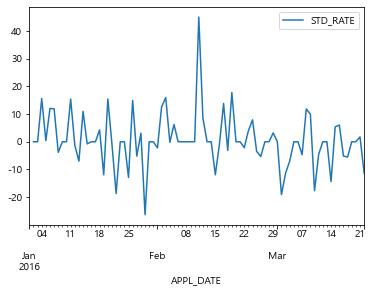

In [52]:
# 1차 차분
# shift(n): 앞의 n번째 행의 데이터를 가져옴
df_JPY_diff1 = df_JPY_train - df_JPY_train.shift(1)
df_JPY_diff1.plot()

<AxesSubplot:xlabel='APPL_DATE'>

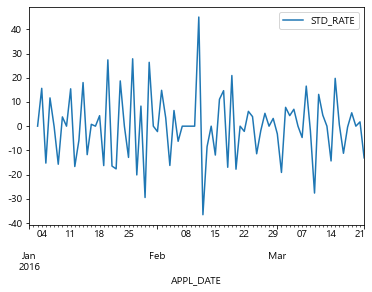

In [53]:
# 2차 차분
df_JPY_diff2 = df_JPY_train - 2 * (df_JPY_train.shift(1)) + (df_JPY_train.shift(2))
df_JPY_diff2.plot()

In [15]:
# 2차 차분으로 결정

### 자기상관 함수 및 부분 자기상관 함수

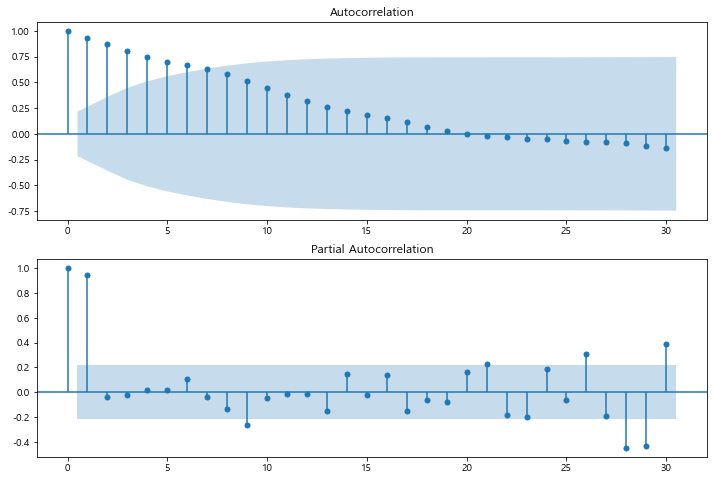

In [54]:
lag_size = 30
fig = plt.figure(figsize = (12, 8))

ax1 = fig.add_subplot(211)
fig = plot_acf(df_JPY_train['STD_RATE'], lags = lag_size, ax = ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df_JPY_train['STD_RATE'], lags = lag_size, ax = ax2)

In [17]:
# p = 1, q = 0

### 시계열 모델

In [55]:
ts_model_jpy = ARIMA(df_JPY_train, order = (1, 2, 0))

#데이터 적합
ts_result_jpy = ts_model_jpy.fit(trend = 'c', full_output = True)
print(ts_result_jpy.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -313.420
Method:                       css-mle   S.D. of innovations             12.149
Date:                Tue, 08 Feb 2022   AIC                            632.841
Time:                        15:15:47   BIC                            639.987
Sample:                    01-03-2016   HQIC                           635.706
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0896      0.925     -0.097      0.923      -1.903       1.724
ar.L1.D2.STD_RATE    -0.4739      0.098     -4.844      0.000      -0.666      -0.282
                        

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will 

### 예측 및 결과 해석

starttime 2016-03-23 00:00:00
endtime 2016-03-31 00:00:00


C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


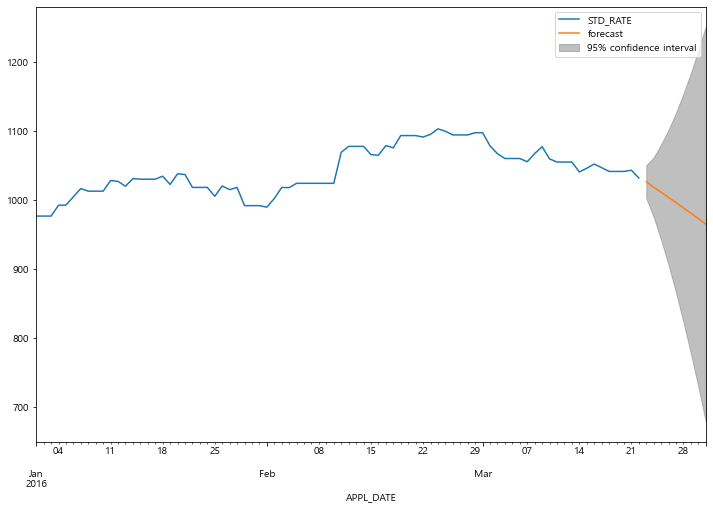

In [56]:
start_time = df_JPY_test.index.min()
print('starttime', start_time)
end_time = df_JPY_test.index.max()
print('endtime', end_time)

fig, ax = plt.subplots(figsize = (12, 8))
ax = df_JPY_train.plot(ax = ax)

fig = ts_result_jpy.plot_predict(start = start_time, end = end_time, ax = ax, plot_insample = False)

- 2016년 3월 31일까지의 예측값 -> 지속적으로 감소할 것으로 예측 

In [20]:
# 전체 기간의 실제값, 예측값 확인

start_time = pd.to_datetime('2016-01-03')
y_pred = ts_result_cny.predict(start = start_time, end = end_time, typ = 'levels')
df_merge = df_CNY
df_merge['예측값'] = y_pred
df_merge.head()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.477844
2016-01-04,181.10,181.476897
2016-01-05,181.94,180.883667


In [21]:
df_merge.shape

(91, 2)

<AxesSubplot:xlabel='APPL_DATE'>

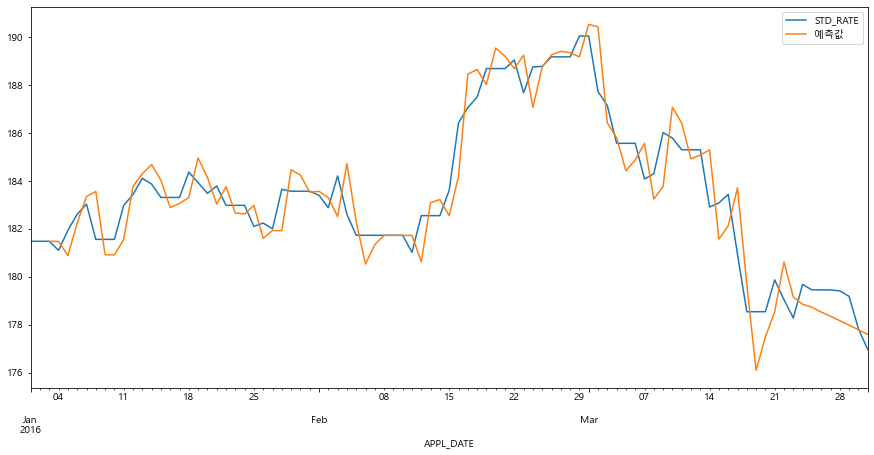

In [22]:
df_merge.plot(y = ['STD_RATE', '예측값'], figsize = (15, 7))